# Customer Satisfaction - Santander

<h4> The objective of this project is to identify dissatisfied customers early in their relationship
with use of machine learning algorithms. Doing so would allow Santander to take
proactive steps to improve a customer's happiness before it's too late. Solutions from this
project will be feed into Kaggle Competition hosted by Santander </h4>

**Evaluation metric** for the outcome on this project is **area under the ROC curve (AUC)**
AUC is calculated from a graphical plot curves typically feature true positive rate on the Y
axis, and false positive rate on the X axis. This means that the top left corner of the plot is
the “ideal” point - a false positive rate of zero, and a true positive rate of one. 

![Example of AUC Curve](Auc.PNG)

**import required libraries to this notebook instance**

In [1]:
import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
# will use ExtraTreesClassifier for feature selection

In [2]:
# sagemaker libraries
import boto3
import sagemaker

## Step 1 - Data loading and Feature Selection

**Overview of Data** \
Will be using the data provided to us in Kaggle Competition - (https://www.kaggle.com/c/santander-customer-satisfaction/data) \
\
There are 3 files in directory
1. train.csv - the training set including the target
2. test.csv - the test set without the target
3. sample_submission.csv - a sample submission file in the correct format



This data is uploaded to Notebook instance - project folder

In [3]:
# Read Data from notebook current folder
train_df = pd.read_csv('Data/train.csv')
test_submission = pd.read_csv('Data/test.csv')
# print out the shape of both the datasets
print("train shape (rows, columns ) = ",train_df.shape, "test shape (rows, columns)", test_submission.shape)

train shape (rows, columns ) =  (76020, 371) test shape (rows, columns) (75818, 370)


370 columns are test and train, all are anonymized. The only column difference between Train and Test is "Target" Variable as intended

*Please note that , the test_submission data will be used only for submission once model training is completed* \
*To test our model, will split the training data further into validation, test dataset later*

In [4]:
# Let's look at top 5 obseravations
train_df.head(5)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


Many features but all are anonymized, So next few steps would be focus on dropping unnecessary columns

In [5]:
#Find out column data types
train_df.dtypes.value_counts()

int64      260
float64    111
dtype: int64

Well, there are no categorical variables.

In [6]:
# Since there are many columns, not able to view all variable disribution metrics in output view 
# So Let's plot Standard deviation of variables to check the distribution

In [7]:
# Copy to dataset
summary_df=train_df.describe()

In [8]:
# view top 5
summary_df.head(5)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,117235.809430,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,182664.598503,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5163.750000,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67870.612500,0.000000


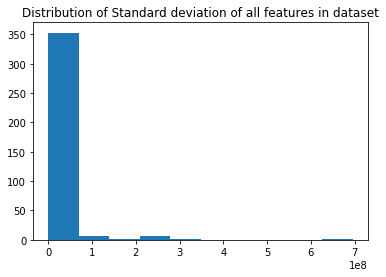

In [189]:
# Plotting STD of all variables
plt.hist(summary_df.iloc[2])
plt.title("Distribution of Standard deviation of all features in dataset")
plt.savefig('STD of features.png')
plt.show()

**Seems few variables has Zero Standard deviation. Zero variance variables doesnt bring value to the model prediction power**

In [10]:
# Create a list of variables with Zero STD to drop
drop_columns = summary_df.iloc[2][summary_df.iloc[2] == 0].index.to_list()

In [191]:
print(len(drop_columns))
print(drop_columns)

34
['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']


In [11]:
# Drop columns now
train_df.drop(drop_columns, axis=1, inplace = True)

In [12]:
# print out the shape of both the datasets after dropping columns
print("train shape (rows, columns ) = ",train_df.shape)

train shape (rows, columns ) =  (76020, 337)


**Drop duplicate columns** - *which are common in Kaggle Competitions*

In [13]:
def dropDuplicates(df):
    '''Function to find duplicate columns in dataframe
       df: dataset'''
    # Declare a list to append the results
    duplicate_columns = []
    # Temp Variable - to store number of columns
    tot_cols = df.shape[1]
    # will reiterate through sequential findings
    for base_col in range(tot_cols):
        col_sel = df.iloc[:,base_col]
        # iterate through all columns
        for compare_with in range(base_col+1, df.shape[1]):
            compare_col = df.iloc[:,compare_with]
            if col_sel.equals(compare_col):
                duplicate_columns.append(df.columns.values[compare_with])
    return duplicate_columns

In [14]:
%%time
# Call to function
duplicate_columns =dropDuplicates(train_df);
# Print identified duplicate columns
print("duplicate columns \n :",duplicate_columns)

duplicate columns 
 : ['ind_var29_0', 'ind_var29', 'ind_var13_medio', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var32', 'ind_var34', 'ind_var37', 'ind_var39', 'num_var29_0', 'num_var29', 'num_var13_medio', 'num_var18', 'num_var26', 'num_var25', 'num_var32', 'num_var34', 'num_var37', 'num_var39', 'saldo_var29', 'saldo_medio_var13_medio_ult1', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3']
CPU times: user 3min 52s, sys: 1min 7s, total: 5min
Wall time: 5min


In [192]:
print(len(duplicate_columns))

29


In [15]:
# Drop duplicate columns
train_df.drop(duplicate_columns, axis=1, inplace = True)

# print out the shape of both the datasets after dropping columns
print("train shape (rows, columns ) = ",train_df.shape)

train shape (rows, columns ) =  (76020, 308)


In [16]:
# Drop ID column which is a record identifier
train_df.drop('ID', axis=1, inplace = True)

In [17]:
# print out the shape of both the datasets after dropping columns
print("train shape (rows, columns ) = ",train_df.shape)

train shape (rows, columns ) =  (76020, 307)


Satisfied Customers =  96.04314654038411 Unsatisfied customers =  3.9568534596158904


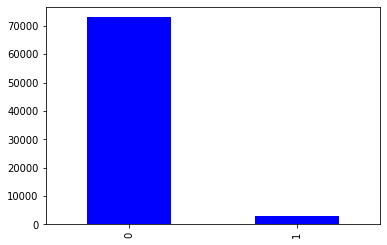

In [194]:
train_df.TARGET.value_counts().plot(kind='bar',color='blue')
# Look at the target Variable distribution
print("Satisfied Customers = ",100*train_df.TARGET.value_counts()[0]/train_df.shape[0],"Unsatisfied customers = ",100*train_df.TARGET.value_counts()[1]/train_df.shape[0])

**Data is baised,should factor this in model development**

In [19]:
# Chekc if any variables has null values
# Store in temporary dataset, as we can't view all columns with Jupyter limitations
Ds = train_df.isnull().sum()/train_df.shape[0]
# Filter only variables with atlest one null value
Ds[Ds > 1]

Series([], dtype: float64)

*No null values in the dataset*

c300 features in our training dataset, this would imply lot of cost on model development and training
Hence, we would be apply dimentionaly reduction methods to choose the top best features which helps us to predict in variation in target variable

There are many dimentionality reduction methods such as PCA, SelectKbest, Chi-Square..etc. We would be using ExtraTreesClassifier to choose the best features based on importance

**Overview of ExtraTreesClassifier** \
Extremely Randomized Trees Classifier(Extra Trees Classifier) is a type of ensemble learning technique which aggregates the results of multiple de-correlated decision trees collected in a “forest” to output it’s classification result. In concept, it is very similar to a Random Forest Classifier and only differs from it in the manner of construction of the decision trees in the forest. (source - geeksforgeeks.org) \

ExtraTreeClassifer Module - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

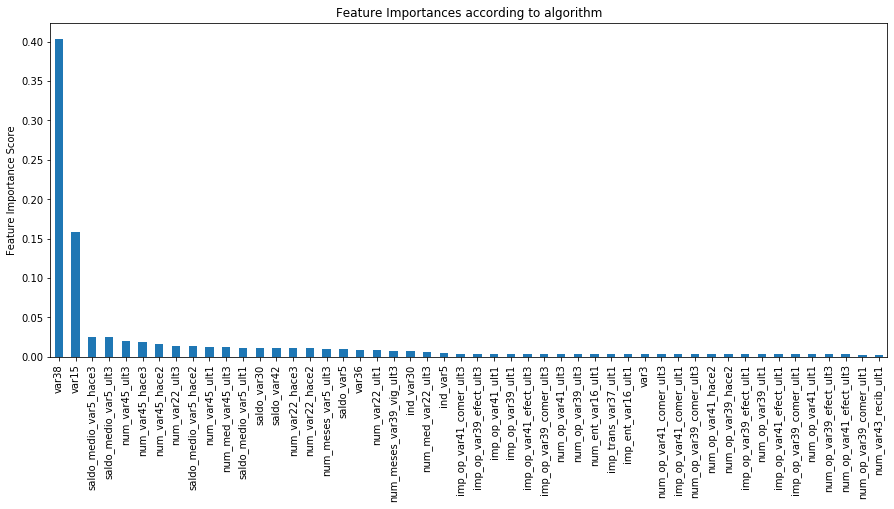

In [196]:
## # Feature selection with ExtraTreesClassifier
clf = ExtraTreesClassifier(random_state = 69)
selector = clf.fit(train_df.drop(['TARGET'],axis=1),train_df['TARGET'])

# plot most important features
feat_imp = pd.Series(clf.feature_importances_, index = train_df.drop(['TARGET'],axis=1).columns.values).sort_values(ascending = False)
# Visualise Top 50 features
feat_imp[:50].plot(kind = 'bar', title = 'Feature Importances according to algorithm', 
                   figsize = (15, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom = 0.3)
plt.savefig('Featureimportance.png')
plt.show()

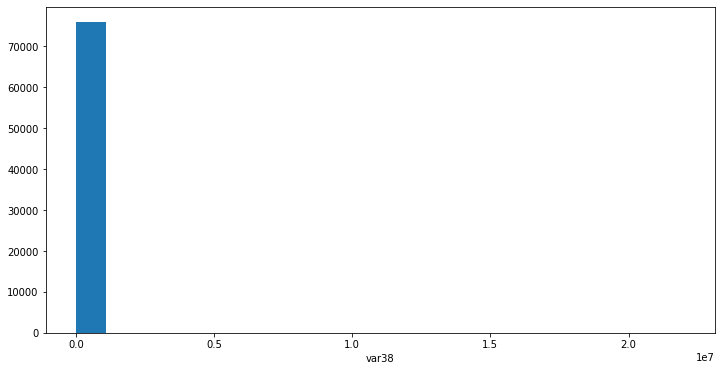

In [21]:
# Let's explore Var38 as it's having high feature importance score
plt.figure(figsize=(12,6))
plt.hist(train_df['var38'],bins=20)
plt.xlabel('var38')
plt.show()

In [22]:
## Seems this feature has few big values - let's find out Max and Minimum
print("Minimum of Var38:",train_df.var38.min(),"\nMaximum of Var38:",train_df.var38.max())

Minimum of Var38: 5163.75 
Maximum of Var38: 22034738.76


In [197]:
## Find out standard deviation of var38.
print("Standard deviation of Var38:",train_df.var38.std())

Standard deviation of Var38: 182664.59850288328


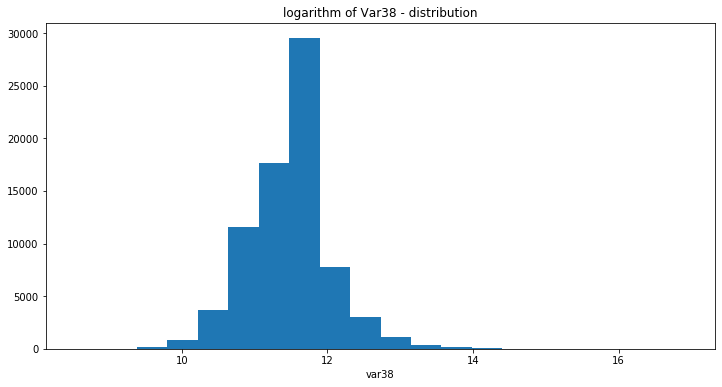

In [23]:
## Data is skewed due to high values for this feature, let's apply log and view
plt.figure(figsize=(12,6))
plt.hist(np.log(train_df['var38']),bins=20)
plt.xlabel('var38')
plt.title("logarithm of Var38 - distribution")
plt.show()

Minimum of var15: 5 
Maximum of Var38: 105
Standard deviation of var15: 12.956485816413004


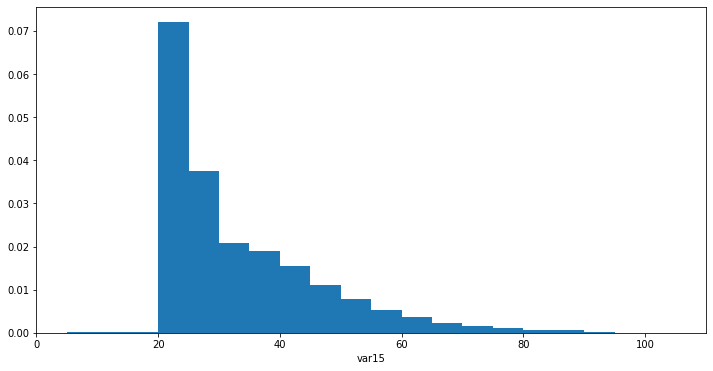

In [198]:
# Let's explore Var15 as it's having second highest feature importance score
print("Minimum of var15:",train_df.var15.min(),"\nMaximum of Var38:",train_df.var15.max())
print("Standard deviation of var15:",train_df.var15.std())
plt.figure(figsize=(12,6))
plt.hist(train_df['var15'],bins=20,density = True, stacked = True)
plt.xlabel('var15')
plt.show()

*Look, this variable represents age of a customer*

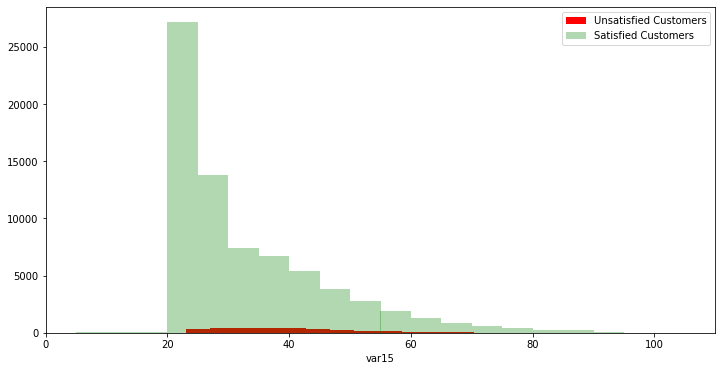

In [199]:
# Let's distribute this plot by target
plt.figure(figsize=(12,6))
x1 = train_df.loc[train_df.TARGET==1, 'var15']
x2 = train_df.loc[train_df.TARGET==0, 'var15']
plt.hist(x1,bins=20,alpha =1,color='r', label='Unsatisfied Customers')
plt.hist(x2,bins=20,alpha =0.3,color='g', label='Satisfied Customers')
plt.xlabel('var15')
plt.legend()
plt.show()

Unsatisfied Customers are spread over from age 25 to 70. But Customer satisfcation levels are good in age old customers compare to middle age

In [86]:
# Select top 40 features for model development , as these features collectively explain the decent variance in target variable;
Top_Features = feat_imp[:40].index.to_list()

In [87]:
Top_Features

['var38',
 'var15',
 'saldo_medio_var5_hace3',
 'saldo_medio_var5_ult3',
 'num_var45_ult3',
 'num_var45_hace3',
 'num_var45_hace2',
 'num_var22_ult3',
 'saldo_medio_var5_hace2',
 'num_var45_ult1',
 'num_med_var45_ult3',
 'saldo_medio_var5_ult1',
 'saldo_var30',
 'saldo_var42',
 'num_var22_hace3',
 'num_var22_hace2',
 'num_meses_var5_ult3',
 'saldo_var5',
 'var36',
 'num_var22_ult1',
 'num_meses_var39_vig_ult3',
 'ind_var30',
 'num_med_var22_ult3',
 'ind_var5',
 'imp_op_var41_comer_ult3',
 'imp_op_var39_efect_ult3',
 'imp_op_var41_ult1',
 'imp_op_var39_ult1',
 'imp_op_var41_efect_ult3',
 'imp_op_var39_comer_ult3',
 'num_op_var41_ult3',
 'num_op_var39_ult3',
 'num_ent_var16_ult1',
 'imp_trans_var37_ult1',
 'imp_ent_var16_ult1',
 'var3',
 'num_op_var41_comer_ult3',
 'imp_op_var41_comer_ult1',
 'num_op_var39_comer_ult3',
 'num_op_var41_hace2']

### Now this data is ready for modelling

In [88]:
## Split the data for train/Validation - as given test data would be used only for submission.
from sklearn.model_selection import train_test_split

In [89]:
#Step 1- split the data to train and test with 80:20%
#Let's choose stratified sampling based on target variale as our data is baised
X_train, X_test, y_train, y_test = train_test_split(train_df[Top_Features], train_df['TARGET'], test_size=0.20,stratify = train_df.TARGET, random_state=42)

In [90]:
#Step 2- further split the train data to train and validation with 80:20%
# our final datsets would be train -60% validation - 20% test- 20%
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,test_size=0.20,stratify = y_train, random_state=42)

In [91]:
y_train.value_counts()

0    46727
1     1925
Name: TARGET, dtype: int64

In [92]:
print("Unsatisfied Customers % in training dataset",100*y_train.value_counts()[1]/y_train.shape[0],\
      "% in validation dataset = ",100*y_validation.value_counts()[1]/y_validation.shape[0],\
      "% in validation dataset = ",100*y_test.value_counts()[1]/y_test.shape[0])

Unsatisfied Customers % in training dataset 3.9566718737153663 % in validation dataset =  3.9542913515291023 % in validation dataset =  3.9594843462246776


In [93]:
# Split looks good

In [94]:
print('Training data points: ', len(X_train))
print('Validation data points: ', len(X_validation))

Training data points:  48652
Validation data points:  12164


In [95]:
# Sagemaker role, session details;
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::160557104793:role/service-role/AmazonSageMaker-ExecutionRole-20210110T103928


In [96]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)

sagemaker-ap-south-1-160557104793


In [97]:
# define location to store model artifacts
prefix = 'customer_satisfaction'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-ap-south-1-160557104793/customer_satisfaction/


Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format. For this example, we'll stick to CSV. Note that the first column must be the target variable and the CSV should not include headers.

In [98]:
# Training dataframe
pd.concat([y_train,X_train], axis=1).to_csv('train.csv', index=False, header=False)

In [99]:
#Validation dataframe
pd.concat([y_validation,X_validation], axis=1).to_csv('validation.csv', index=False, header=False)

In [100]:
# Upload to S3
session.upload_data(path='train.csv', bucket=bucket_name, key_prefix=prefix+'/train/train.csv')
session.upload_data(path='validation.csv', bucket=bucket_name, key_prefix=prefix+'/validation/validation.csv')

's3://sagemaker-ap-south-1-160557104793/customer_satisfaction/validation/validation.csv/validation.csv'

In [101]:
# we'll create s3_inputs that our training function can use as a pointer to the files in S3
from sagemaker.inputs import TrainingInput
s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket_name, prefix), content_type='csv')

In [102]:
# Training parameters - XGboost
from sagemaker import image_uris
container = image_uris.retrieve('xgboost', boto3.Session().region_name, '1.2-1' )

In [112]:
# Load Estimator
from sagemaker.estimator import Estimator

In [172]:
# Create XGboost model
xgb = Estimator(container,
                role,
                instance_count=1,
                instance_type='ml.m4.xlarge',
                output_path='s3://{}/{}/output'.format(bucket_name, prefix))

xgb.set_hyperparameters( max_depth=5,
                         min_child_weight=1,
                         gamma= 0,
                         subsample= 0.8,
                         colsample_bytree= 0.8,
                         objective= 'binary:logistic',
                         nthread=4,
                         eval_metric ='auc',
                         scale_pos_weight=0.396,
                         seed=4242,
                         num_round=30)
# scale_pos_weight - 0.396 represents % of unsatisfied customers in our train dataset
# after few experimentations - decided with this hyperparameters set

In [173]:
# Fit XGboost model
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-02-28 13:25:44 Starting - Starting the training job...
2021-02-28 13:26:07 Starting - Launching requested ML instancesProfilerReport-1614518743: InProgress
......
2021-02-28 13:27:08 Starting - Preparing the instances for training.........
2021-02-28 13:28:29 Downloading - Downloading input data
2021-02-28 13:28:29 Training - Downloading the training image.....[2021-02-28 13:29:20.580 ip-10-0-113-175.ap-south-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delim

In [174]:
# Deploy XGboost model
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

---------------!

In [175]:
#Our data is currently stored as NumPy arrays in memory of our notebook instance, let's serialise the data to pass our testdata to predict probability 
from sagemaker.serializers import CSVSerializer
xgb_predictor.serializer = CSVSerializer()

In [176]:
# Convert our test data to  mini-batches to CSV string payloads and collect predictions
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(X_validation.values)

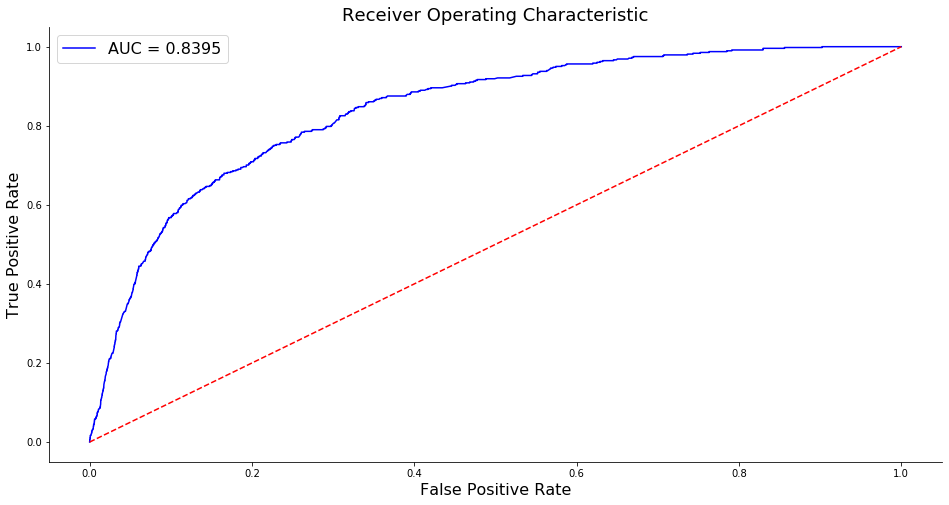

In [208]:
# Let's plot ROC and calculate AUC
import sklearn.metrics as metrics
#Calculate FPR and TPR for all thresholds
fpr, tpr, threshold = metrics.roc_curve(y_validation, predictions)
roc_auc = metrics.auc(fpr, tpr)
# Plotting the ROC curve
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (16, 8))
plt.title('Receiver Operating Characteristic', fontsize=18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc = 'upper left', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.show()

In [178]:
# Prepare the data for submission

In [179]:
submission_prediction = predict(test_submission[Top_Features].values)

In [180]:
pd.DataFrame(submission_prediction, index = [test_submission.ID], columns = ['TARGET']).to_csv('submission.csv')

In [184]:
xgb_predictor.delete_endpoint()

# Linear Learner

In [154]:
# import LinearLearner
from sagemaker import LinearLearner
# instantiate LinearLearner
# Option 1
#
#linear = LinearLearner(role=role,
#                       train_instance_count=1, 
#                       train_instance_type='ml.c4.xlarge',
#                       predictor_type='binary_classifier',
#                       output_path=output_path,
#                       sagemaker_session=session,
#                       epochs=15) */
# Option 2
#linear = LinearLearner(role=role,
#                                train_instance_count=1, 
#                                train_instance_type='ml.c4.xlarge',
#                                predictor_type='binary_classifier',
#                                output_path=output_path,
#                                sagemaker_session=session,
#                                epochs=15,
#                                binary_classifier_model_selection_criteria='f_beta',
#                                positive_example_weight_mult='balanced')

# Option 3
linear = LinearLearner(role=role,
                                train_instance_count=1, 
                                train_instance_type='ml.c4.xlarge',
                                predictor_type='binary_classifier',
                                output_path=output_path,
                                sagemaker_session=session,
                                epochs=15,
                                binary_classifier_model_selection_criteria='f_beta',
                                positive_example_weight_mult='auto')

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [156]:
# convert features/labels to numpy
# Since we dont need validation data specifacally for Linear learner, let's devide the data again into test and train split
#Let's choose stratified sampling based on target variale as our data is baised
X_train_ls, X_test_ls, y_train_ls, y_test_ls = train_test_split(train_df[Top_Features], train_df['TARGET'], test_size=0.30,stratify = train_df.TARGET, random_state=42)
# Convert data into numpy;
train_x_np = X_train_ls.values.astype('float32')
train_y_np = y_train_ls.values.astype('float32')
# create RecordSet
formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

In [157]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-02-28 13:05:41 Starting - Starting the training job...
2021-02-28 13:06:06 Starting - Launching requested ML instancesProfilerReport-1614517541: InProgress
......
2021-02-28 13:07:07 Starting - Preparing the instances for training......
2021-02-28 13:08:12 Downloading - Downloading input data...
2021-02-28 13:08:30 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[02/28/2021 13:08:53 INFO 139728157366080] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'a

In [158]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!CPU times: user 277 ms, sys: 10.2 ms, total: 288 ms
Wall time: 7min 32s


In [159]:
# test one prediction
#X_train_ls, X_test_ls, y_train_ls, y_test_ls
test_x_np = X_test_ls.values.astype('float32')
result = linear_predictor.predict(test_x_np[0])

print(result)

[label {
  key: "predicted_label"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "score"
  value {
    float32_tensor {
      values: 0.47712865471839905
    }
  }
}
]


In [160]:
def predict_LLearner(predictor, test_features):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['score'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    return test_preds

In [163]:
predictions_ll = predict_LLearner(linear_predictor,X_test_ls.values.astype('float32'))

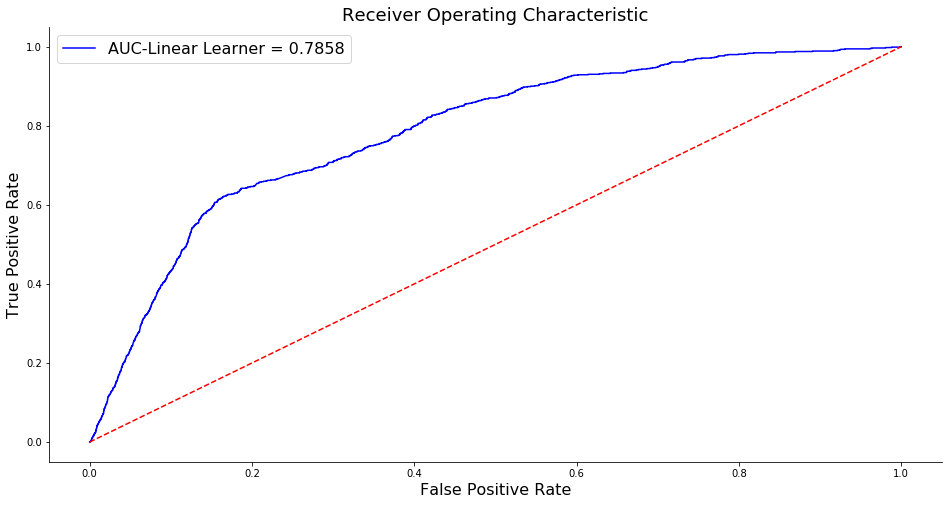

In [205]:
# Let's plot ROC and calculate AUC
import sklearn.metrics as metrics
#Calculate FPR and TPR for all thresholds
fpr_ll, tpr_ll, threshold = metrics.roc_curve(y_test_ls.values, predictions_ll)
roc_auc_ll = metrics.auc(fpr_ll, tpr_ll)
# Plotting the ROC curve
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (16, 8))
plt.title('Receiver Operating Characteristic', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(fpr_ll, tpr_ll, 'b', label = 'AUC-Linear Learner = %0.4f' % roc_auc_ll)
plt.legend(loc = 'upper left', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.show()

### Comparision of both models

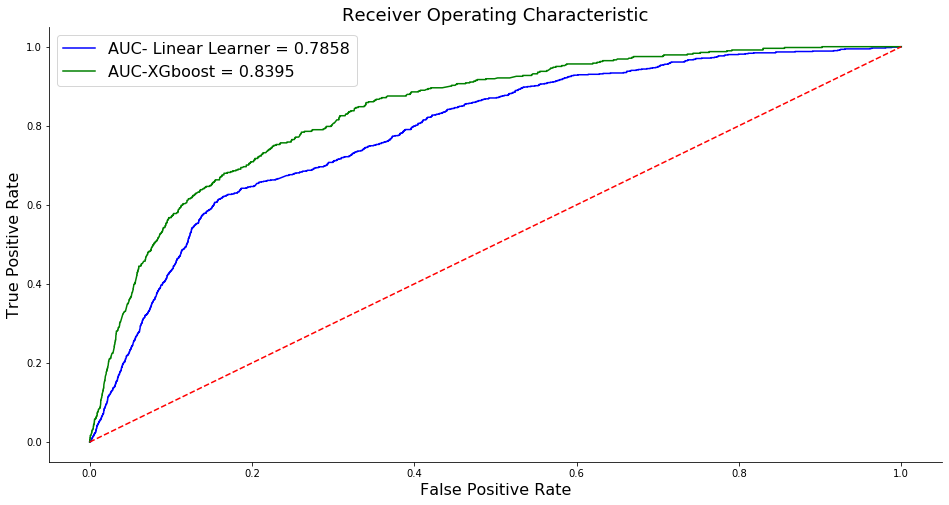

In [209]:
# Let's plot ROC and calculate AUC
import sklearn.metrics as metrics
#Calculate FPR and TPR for all thresholds
fpr_ll, tpr_ll, threshold = metrics.roc_curve(y_test_ls.values, predictions_ll)
roc_auc_ll = metrics.auc(fpr_ll, tpr_ll)
# Plotting the ROC curve
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (16, 8))
plt.title('Receiver Operating Characteristic', fontsize=18)
plt.plot(fpr_ll, tpr_ll, 'b', label = 'AUC- Linear Learner = %0.4f' % roc_auc_ll)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(fpr, tpr, 'g', label = 'AUC-XGboost = %0.4f' % roc_auc)
plt.legend(loc = 'upper left', fontsize = 16)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.show()

In [185]:
# Delete endpoint
linear_predictor.delete_endpoint()